In [2]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/Downloads/aou/"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y_binary.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'E_binary.rds')))
E = E.astype(int)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)


In [5]:
# Get dimensions
N, D, T = Y_tensor.shape
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 20  # number of topics


In [13]:
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Downloads/aou/diagnames.rds'))
disease_names = disease_names[0].tolist()

In [14]:
# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)


Tensor shapes:
Y: torch.Size([10000, 348, 51])
E: torch.Size([10000, 348])
Time range: 0 to 50
51
20


In [15]:
E_tensor 

tensor([[50., 50., 50.,  ..., 50., 50., 17.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        ...,
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 41.]])

In [10]:
from cluster_g_logit_init import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [11]:
Y = torch.tensor(Y, dtype=torch.float32)
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)


In [16]:
prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
epsilon = 1e-8
logit_prev_t = torch.log((prevalence_t + epsilon) / (1 - prevalence_t + epsilon))
lambda_length_scale = T/4

Y_avg = torch.mean(Y, dim=2)
epsilon=1e-8
Y_avg = torch.log((Y_avg + epsilon)/(1-Y_avg+epsilon))
Y_corr = torch.corrcoef(Y_avg.T)
similarity = (Y_corr + 1) / 2
            
spectral = SpectralClustering(
    n_clusters=K,
    assign_labels='kmeans',
    affinity='precomputed',
    n_init=10,
    random_state=42
).fit(similarity.numpy())

clusters=spectral.labels_

Y_avg = torch.mean(Y, dim=2)
        
print("\nCluster Assignments:")
for k in range(K):
    print(f"\nCluster {k}:")
    cluster_diseases = [disease_names[i] for i in range(len(clusters)) 
                    if clusters[i] == k]
    # Get prevalence for each disease
    cluster_mask = (clusters == k)
    prevalences = Y_avg[:, cluster_mask].mean(dim=0)
    
    for disease, prev in zip(cluster_diseases, prevalences):
        print(f"  - {disease} (prevalence: {prev:.4f})")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_19073/2107203917.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)



Cluster Assignments:

Cluster 0:
  - Breast cancer [female] (prevalence: 0.0008)
  - Malignant neoplasm of female breast (prevalence: 0.0008)
  - Benign neoplasm of breast (prevalence: 0.0004)
  - Lump or mass in breast (prevalence: 0.0020)

Cluster 1:
  - Gram negative septicemia (prevalence: 0.0002)
  - Bacterial infection NOS (prevalence: 0.0023)
  - Staphylococcus infections (prevalence: 0.0005)
  - Streptococcus infection (prevalence: 0.0004)
  - E. coli (prevalence: 0.0004)
  - Hypoglycemia (prevalence: 0.0005)
  - Disorders of calcium/phosphorus metabolism (prevalence: 0.0009)
  - Hyposmolality and/or hyponatremia (prevalence: 0.0013)
  - Hypopotassemia (prevalence: 0.0020)
  - Acidosis (prevalence: 0.0012)
  - Hypovolemia (prevalence: 0.0021)
  - Other anemias (prevalence: 0.0049)
  - Thrombocytopenia (prevalence: 0.0010)
  - Bipolar (prevalence: 0.0012)
  - Major depressive disorder (prevalence: 0.0050)
  - Anxiety disorder (prevalence: 0.0059)
  - Alcohol-related disorders (

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_19073/1352526393.py:196: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()



Cluster Memberships:

Cluster 0 (4 diseases):
  - Breast cancer [female]
  - Malignant neoplasm of female breast
  - Benign neoplasm of breast
  - Lump or mass in breast

Cluster 1 (38 diseases):
  - Gram negative septicemia
  - Bacterial infection NOS
  - Staphylococcus infections
  - Streptococcus infection
  - E. coli
  - Hypoglycemia
  - Disorders of calcium/phosphorus metabolism
  - Hyposmolality and/or hyponatremia
  - Hypopotassemia
  - Acidosis
  - Hypovolemia
  - Other anemias
  - Thrombocytopenia
  - Bipolar
  - Major depressive disorder
  - Anxiety disorder
  - Alcohol-related disorders
  - Alcoholic liver damage
  - Tobacco use disorder
  - Epilepsy, recurrent seizures, convulsions
  - Inflammatory and toxic neuropathy
  - Other acute and subacute forms of ischemic heart disease
  - Hypotension NOS
  - Dental caries
  - Periapical abscess
  - Other diseases of the teeth and supporting structures
  - Constipation
  - Other chronic nonalcoholic liver disease
  - Other disord

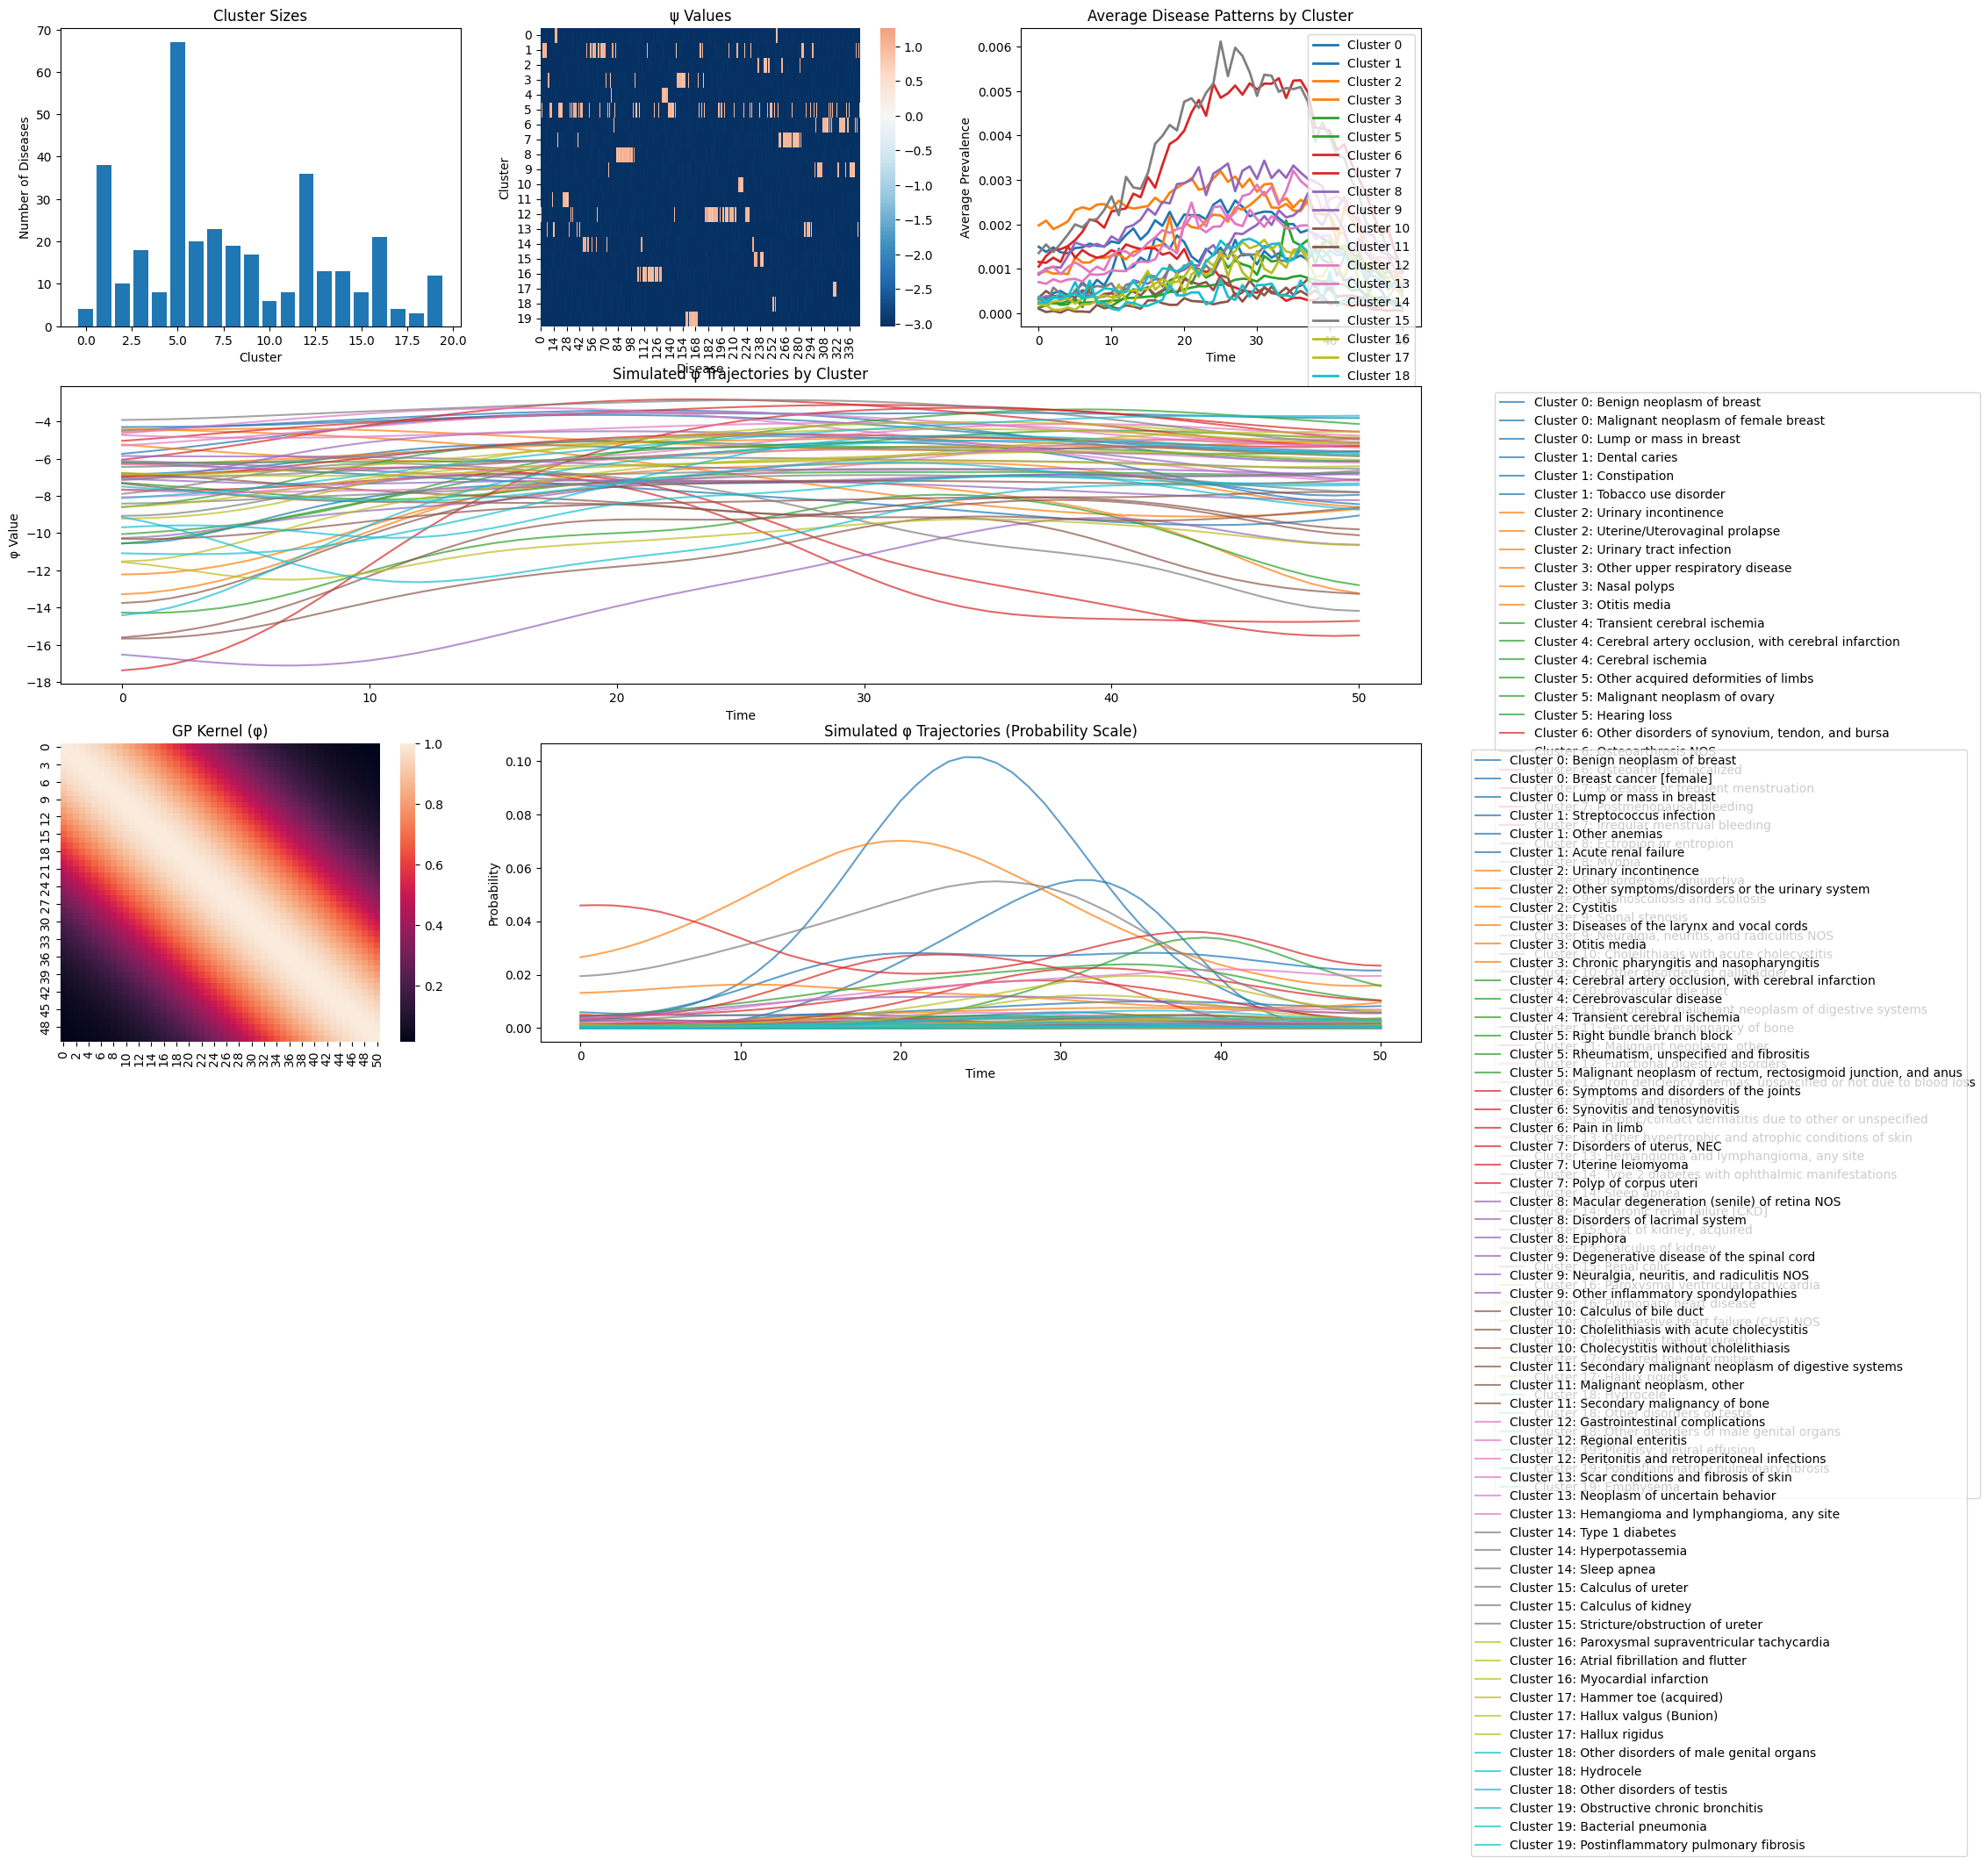

In [17]:
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)
prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
epsilon = 1e-8
logit_prev_t = torch.log((prevalence_t + epsilon) / (1 - prevalence_t + epsilon))

K=20
# Create model
def initialize_disease_clusters(Y, K, T, logit_prev_t, disease_names=None, random_state=42):
    """
    Initialize disease clusters and simulate phi trajectories using GP prior
    
    Parameters:
    Y: numpy array (N x D x T) of disease trajectories
    K: int, number of clusters
    T: int, number of time points
    logit_prev_t: tensor (D x T) of logit prevalence trajectories
    disease_names: list of disease names (optional)
    random_state: int, random seed for reproducibility
    """
    # Convert inputs to torch tensors if needed
    if not isinstance(Y, torch.Tensor):
        Y = torch.tensor(Y, dtype=torch.float32)
    if not isinstance(logit_prev_t, torch.Tensor):
        logit_prev_t = torch.tensor(logit_prev_t, dtype=torch.float32)
    
    N, D, T = Y.shape
    
    # Set kernel parameters as in the model
    lambda_length_scale = T/4
    phi_length_scale = T/3
    amplitude = 1.0
    
    # Compute kernel matrices
    times = torch.arange(T, dtype=torch.float32)
    sq_dists = (times.unsqueeze(0) - times.unsqueeze(1)) ** 2
    K_phi = amplitude ** 2 * torch.exp(-0.5 * sq_dists / (phi_length_scale ** 2))
    jitter = 1e-6
    K_phi = K_phi + jitter * torch.eye(T)
    
    # Perform clustering as before
    Y_avg = torch.mean(Y, dim=2)
    epsilon = 1e-8
    Y_avg = torch.log((Y_avg + epsilon)/(1-Y_avg+epsilon))
    
    Y_corr = torch.corrcoef(Y_avg.T)
    similarity = (Y_corr + 1) / 2
    
    spectral = SpectralClustering(
        n_clusters=K,
        assign_labels='kmeans',
        affinity='precomputed',
        n_init=10,
        random_state=random_state
    ).fit(similarity.numpy())
    
    clusters = spectral.labels_
    
    # Initialize psi
    psi = torch.zeros((K, D))
    for k in range(K):
        cluster_mask = (clusters == k)
        psi[k, cluster_mask] = 1.0 + 0.1 * torch.randn(cluster_mask.sum())
        psi[k, ~cluster_mask] = -3.0 + 0.01 * torch.randn((~cluster_mask).sum())
    
    # Simulate phi using GP prior
    L_phi = torch.linalg.cholesky(K_phi)
    phi = torch.zeros((K, D, T))
    
    for k in range(K):
        for d in range(D):
            mean_phi = logit_prev_t[d, :] + psi[k, d]
            eps = L_phi @ torch.randn(T)
            phi[k, d, :] = mean_phi + eps
    
    # Store cluster information
    cluster_info = {
        'sizes': {},
        'members': {},
        'avg_trajectories': {}
    }
    
    unique, counts = np.unique(clusters, return_counts=True)
    for k, count in zip(unique, counts):
        cluster_info['sizes'][k] = count.item()
        cluster_mask = (clusters == k)
        
        if disease_names is not None:
            members = [disease_names[i] for i in range(D) if cluster_mask[i]]
        else:
            members = [i for i in range(D) if cluster_mask[i]]
        
        cluster_info['members'][k] = members
        cluster_info['avg_trajectories'][k] = Y_avg[:, cluster_mask].mean(dim=1)
    
    return {
        'clusters': clusters,
        'psi': psi,
        'phi': phi,
        'cluster_info': cluster_info,
        'K_phi': K_phi
    }




def plot_cluster_results(cluster_results, Y, disease_names=None, n_example_trajectories=3):
    """
    Visualize clustering results including simulated phi trajectories
    """
    K = cluster_results['psi'].shape[0]
    D = Y.shape[1]
    T = Y.shape[2]
    
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 3)
    
    # Plot 1: Cluster sizes
    ax1 = fig.add_subplot(gs[0, 0])
    sizes = list(cluster_results['cluster_info']['sizes'].values())
    ax1.bar(range(K), sizes)
    ax1.set_title('Cluster Sizes')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Number of Diseases')
    
    # Plot 2: Psi heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(cluster_results['psi'].numpy(), 
                cmap='RdBu_r', 
                center=0,
                ax=ax2)
    ax2.set_title('ψ Values')
    ax2.set_xlabel('Disease')
    ax2.set_ylabel('Cluster')
    
    # Plot 3: Average temporal patterns
    ax3 = fig.add_subplot(gs[0, 2])
    Y_avg = torch.mean(Y, dim=0).numpy()
    clusters = cluster_results['clusters']
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_avg = Y_avg[cluster_mask].mean(axis=0)
        ax3.plot(cluster_avg, color=colors[k], label=f'Cluster {k}', linewidth=2)
    ax3.set_title('Average Disease Patterns by Cluster')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Average Prevalence')
    ax3.legend()
    
    # Plot 4: Simulated phi trajectories
    ax4 = fig.add_subplot(gs[1, :])
    phi = cluster_results['phi']
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_diseases = np.where(cluster_mask)[0]
        
        # Select random examples
        n_examples = min(n_example_trajectories, len(cluster_diseases))
        example_diseases = np.random.choice(cluster_diseases, n_examples, replace=False)
        
        for d in example_diseases:
            label = f'Cluster {k}: ' + (disease_names[d] if disease_names is not None else f'Disease {d}')
            ax4.plot(phi[k, d, :].numpy(), color=colors[k], alpha=0.7, label=label)
    
    ax4.set_title('Simulated φ Trajectories by Cluster')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('φ Value')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 5: GP kernel
    ax5 = fig.add_subplot(gs[2, 0])
    sns.heatmap(cluster_results['K_phi'].numpy(), ax=ax5)
    ax5.set_title('GP Kernel (φ)')
    
    # Plot transformed phi (probability scale)
    ax6 = fig.add_subplot(gs[2, 1:])
    phi_prob = torch.sigmoid(phi)
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_diseases = np.where(cluster_mask)[0]
        
        n_examples = min(n_example_trajectories, len(cluster_diseases))
        example_diseases = np.random.choice(cluster_diseases, n_examples, replace=False)
        
        for d in example_diseases:
            label = f'Cluster {k}: ' + (disease_names[d] if disease_names is not None else f'Disease {d}')
            ax6.plot(phi_prob[k, d, :].numpy(), color=colors[k], alpha=0.7, label=label)
    
    ax6.set_title('Simulated φ Trajectories (Probability Scale)')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Probability')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Print cluster memberships
    print("\nCluster Memberships:")
    for k in range(K):
        print(f"\nCluster {k} ({cluster_results['cluster_info']['sizes'][k]} diseases):")
        members = cluster_results['cluster_info']['members'][k]
        if disease_names is not None:
            for member in members:
                print(f"  - {member}")
    
    plt.show()

# Example usage:

cluster_results = initialize_disease_clusters(
    Y=Y,
    K=20,
    T=T,
    logit_prev_t=logit_prev_t,
    disease_names=disease_names
)

plot_cluster_results(cluster_results, Y, disease_names)


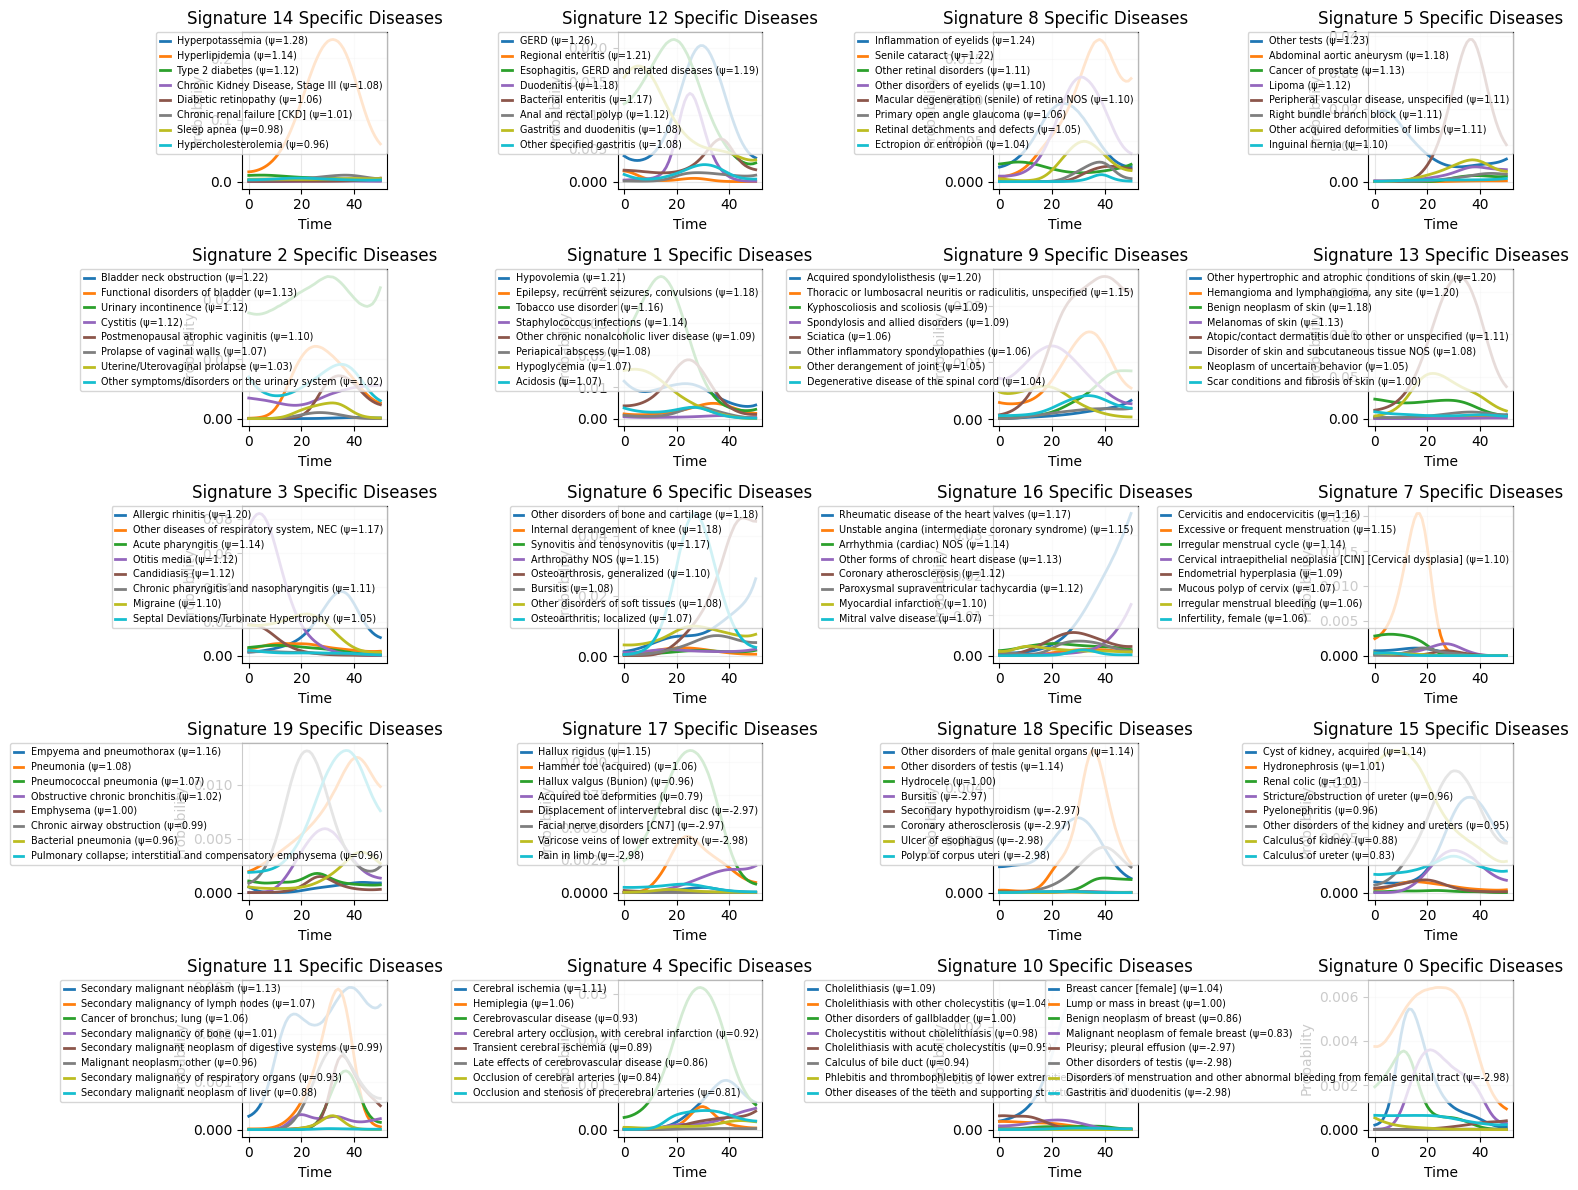

In [18]:
def plot_signature_trajectories(cluster_results, n_signatures=20, n_top_diseases=5, disease_names=None):
    """
    Plot phi trajectories for signature-specific diseases in selected clusters
    
    Parameters:
    cluster_results: output from initialize_disease_clusters
    n_signatures: number of signatures (clusters) to plot
    n_top_diseases: number of most signature-specific diseases to show per cluster
    disease_names: list of disease names (optional)
    """
    K = cluster_results['psi'].shape[0]
    phi = cluster_results['phi']
    psi = cluster_results['psi']
    
    # Select clusters with most distinct patterns (highest psi values)
    cluster_specificity = torch.max(psi, dim=1)[0]  # Maximum psi value per cluster
    top_clusters = torch.argsort(cluster_specificity, descending=True)[:n_signatures]
    
    # Create subplot grid
    fig, axes = plt.subplots(5, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_top_diseases))
    
    for idx, k in enumerate(top_clusters):
        ax = axes[idx]
        
        # Find most specific diseases for this signature
        psi_k = psi[k, :]
        top_diseases = torch.argsort(psi_k, descending=True)[:n_top_diseases]
        
        # Plot phi trajectories
        for i, d in enumerate(top_diseases):
            phi_trajectory = phi[k, d, :].numpy()
            prob_trajectory = torch.sigmoid(phi[k, d, :]).numpy()
            
            label = f"{disease_names[d] if disease_names is not None else f'Disease {d}'} (ψ={psi_k[d]:.2f})"
            
            # Plot on probability scale
            ax.plot(prob_trajectory, color=colors[i], linewidth=2, label=label)
        
        ax.set_title(f'Signature {k} Specific Diseases')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        # Modify legend parameters to fit within each subplot
        ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                 fontsize='x-small',  # Make font smaller
                 framealpha=0.8,      # Make background slightly transparent
                 handlelength=1,      # Shorter lines in legend
                 borderaxespad=0.)    # Reduce padding
        ax.grid(True, alpha=0.3)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave some space on the right
    plt.show()

cluster_results = initialize_disease_clusters(
    Y=Y,
    K=20,
    T=T,
    logit_prev_t=logit_prev_t,
    disease_names=disease_names
)

plot_signature_trajectories(
    cluster_results,
    n_signatures=20,
    n_top_diseases=8,
    disease_names=disease_names
)


In [ ]:

# G should be float64
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)
G_tensor = torch.FloatTensor(G)
print(f"G: {G_tensor.shape}")  # [N, P]